## Time Series Forecasting on Energy Consumption Data Using Machine learning models

## Project Goal

To predict energy consumption data using XGBoost model, Random Forest Model

## Data Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree

from sklearn.metrics import r2_score

In [2]:
# Import csv file
pjme = pd.read_csv(r"F:\IBM\git\Forecasting\energy_dataset.csv")

In [3]:
pjme=pjme.loc[:,['time','total load actual']]

In [4]:
# Fill null values using interpolation


pjme.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [5]:
pjme.time=pd.to_datetime(pjme.time)

In [6]:
pjme.set_index('time',inplace=True)

In [7]:
pjme.shape

(35064, 1)

In [8]:
pjme.head(5)

,total load actual
time,
2014-12-31 23:00:00,25385.0
2015-01-01 00:00:00,24382.0
2015-01-01 01:00:00,22734.0
2015-01-01 02:00:00,21286.0
2015-01-01 03:00:00,20264.0


(array([392709, 394464, 403224, 412008, 420768, 429528, 431279],
       dtype=int64),
 <a list of 7 Text xticklabel objects>)

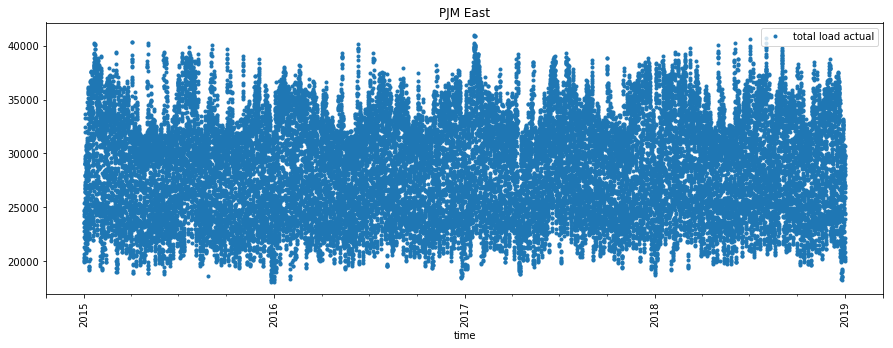

In [9]:
pjme.plot(style='.', figsize=(15,5), title='PJM East');
plt.xticks(rotation=90)

In [10]:
pjme.index

DatetimeIndex(['2014-12-31 23:00:00', '2015-01-01 00:00:00',
               '2015-01-01 01:00:00', '2015-01-01 02:00:00',
               '2015-01-01 03:00:00', '2015-01-01 04:00:00',
               '2015-01-01 05:00:00', '2015-01-01 06:00:00',
               '2015-01-01 07:00:00', '2015-01-01 08:00:00',
               ...
               '2018-12-31 13:00:00', '2018-12-31 14:00:00',
               '2018-12-31 15:00:00', '2018-12-31 16:00:00',
               '2018-12-31 17:00:00', '2018-12-31 18:00:00',
               '2018-12-31 19:00:00', '2018-12-31 20:00:00',
               '2018-12-31 21:00:00', '2018-12-31 22:00:00'],
              dtype='datetime64[ns]', name='time', length=35064, freq=None)

## Building Training/ Test Samples

Data after 2015 will be used as validation set

In [11]:
split_date = '2018-01-01 01:00:00+01:00'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [12]:
len(pjme_train)

26306

In [13]:
len(pjme_test)

8758

(array([392709, 394464, 403224, 412008, 420768, 429528, 431279],
       dtype=int64),
 <a list of 7 Text xticklabel objects>)

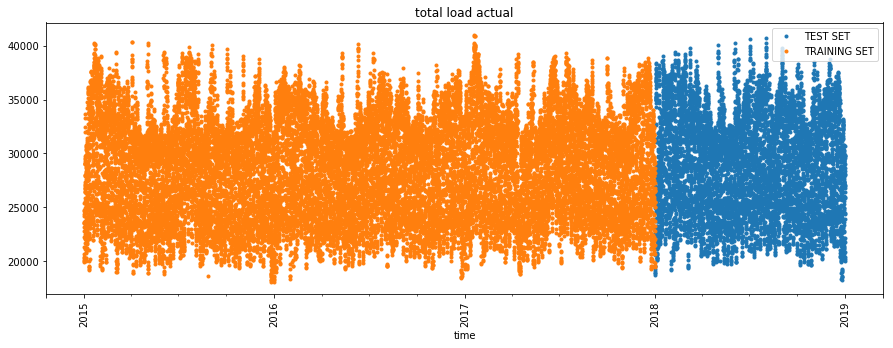

In [14]:
pjme_test \
    .rename(columns={'total load actual': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'total load actual': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='total load actual', style='.');
plt.xticks(rotation=90)


## Features Engineering

In [15]:
# Create features from datetime index
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour', 'dayofweek','month', 'quarter', 'year', 'dayofyear',
            'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X
    

In [16]:
X_train, y_train = create_features(pjme_train, label='total load actual')
X_test, y_test = create_features(pjme_test, label='total load actual')

##  Build XGBoost Model

In [17]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = 50,
        verbose = False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
       gamma=0, gpu_id=-1, importance_type=None,
       interaction_constraints='', learning_rate=0.300000012,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
       monotone_constraints='()', n_estimators=1000, n_jobs=8,
       num_parallel_tree=1, objective='reg:squarederror', predictor='auto',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       subsample=1, tree_method='exact', validate_parameters=1,
       verbosity=None)

## Feature Importances

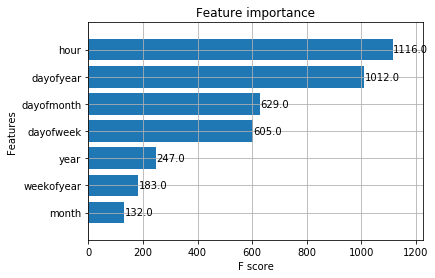

In [18]:
plot_importance(reg, height=0.8);

From the graph, we observe that the day of year was most commonly used,
follow by hour and year. Month has the least importance. 

## Forecast on Test Set

In [19]:
pjme_test['MW_Prediction'] = reg.predict(X_test)

In [20]:
pjme_test.head(5)

,total load actual,date,hour,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear,MW_Prediction
time,,,,,,,,,,,
2018-01-01 01:00:00,20589.0,2018-01-01 01:00:00,1,0,1,1,2018,1,1,1,21598.820312
2018-01-01 02:00:00,19547.0,2018-01-01 02:00:00,2,0,1,1,2018,1,1,1,21391.060547
2018-01-01 03:00:00,18871.0,2018-01-01 03:00:00,3,0,1,1,2018,1,1,1,21391.060547
2018-01-01 04:00:00,18688.0,2018-01-01 04:00:00,4,0,1,1,2018,1,1,1,21080.166016
2018-01-01 05:00:00,18869.0,2018-01-01 05:00:00,5,0,1,1,2018,1,1,1,23010.320312


In [21]:
pjme_all = pd.concat([pjme_test, pjme_train], sort = False)

In [22]:
pjme_all.shape

(35064, 11)

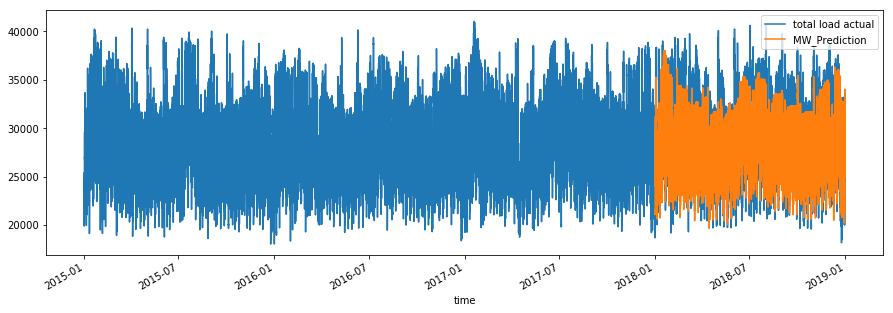

In [23]:
pjme_all[['total load actual', 'MW_Prediction']].plot(figsize=(15,5));

## Check first month of predictions

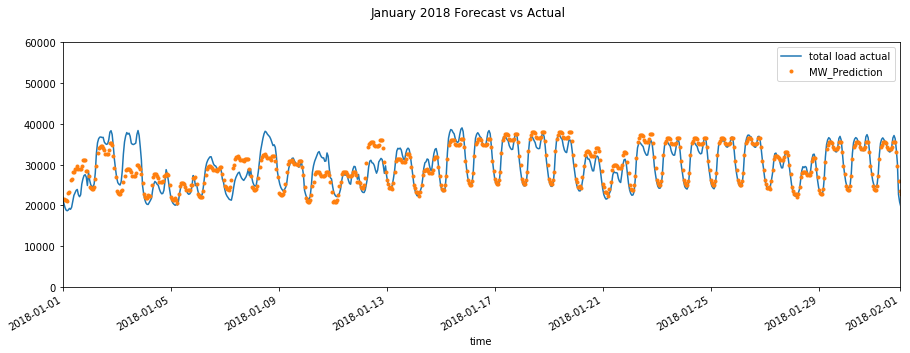

In [24]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = pjme_all[['total load actual', 'MW_Prediction']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='01-01-2018', upper='02-01-2018')
ax.set_ylim(0, 60000)

plot = plt.suptitle('January 2018 Forecast vs Actual')

## Check first week of January predictions

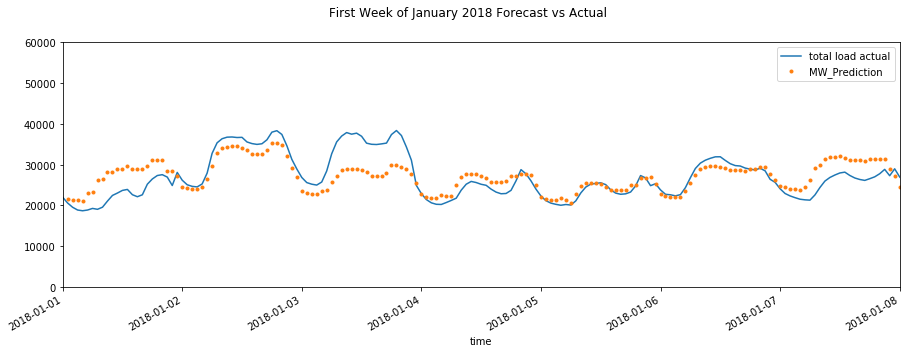

In [25]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = pjme_all[['total load actual', 'MW_Prediction']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='01-01-2018', upper='01-08-2018')
ax.set_ylim(0, 60000)

plot = plt.suptitle('First Week of January 2018 Forecast vs Actual')

## Check first week of August predictions

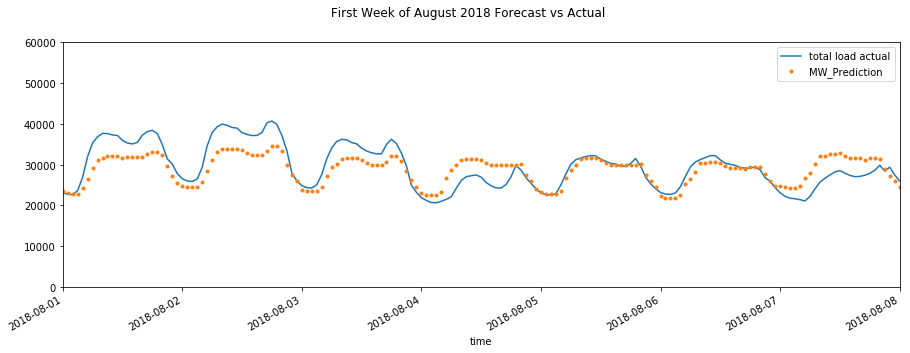

In [26]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = pjme_all[['total load actual', 'MW_Prediction']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='08-01-2018', upper='08-08-2018')
ax.set_ylim(0, 60000)

plot = plt.suptitle('First Week of August 2018 Forecast vs Actual')

## Evaluate the Performance

In [27]:
# The MAPE (Mean Absolute Percent Error) measures the size of the error
# in percentage terms.
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
# Make predictions using the training and testing set
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [29]:
print('R^2   train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('MSE   train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))

print('RMSE  train: %.2f, test: %.2f' %
      (np.sqrt(mean_squared_error(y_train, y_train_pred)),
       np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('MAE   train: %.2f, test: %.2f' %
      (mean_absolute_error(y_train, y_train_pred),
       mean_absolute_error(y_test, y_test_pred)))

print('MAPE  train: %.2f, test: %.2f' %
      (mean_absolute_percentage_error(y_train, y_train_pred),
       mean_absolute_percentage_error(y_test, y_test_pred)))

R^2   train: 0.85, test: 0.75
MSE   train: 3043188.70, test: 5397958.50
RMSE  train: 1744.47, test: 2323.35
MAE   train: 1248.96, test: 1709.89
MAPE  train: 4.39, test: 5.84


The Mean absolute percent accuracy (MAPA) is 94.16% (100 - 5.84)

## Check Best and Worst Predicted Day

In [30]:
pjme_test['error'] = pjme_test['total load actual'] - pjme_test['MW_Prediction']

In [31]:
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)

In [32]:
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['total load actual', 'MW_Prediction', 'error', 'abs_error']]

In [33]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

total load actual  MW_Prediction        error  \
year month dayofmonth                                                  
2018 2     12               26165.375000   32208.269531 -6042.894206   
     3     6                22956.333333   28559.859375 -5603.525391   
     7     10               23940.291667   28934.992188 -4994.701335   
     10    6                23640.833333   28458.648438 -4817.815348   
     3     30               24268.541667   28796.367188 -4527.826172   
     1     1                22712.347826   27071.224609 -4358.876868   
     9     9                24286.833333   28246.324219 -3959.491048   
     1     12               28103.375000   31912.871094 -3809.495280   
     6     5                23435.666667   26999.472656 -3563.805583   
           12               26703.416667   30266.207031 -3562.789632   

                         abs_error  
year month dayofmonth               
2018 2     12          6082.144857  
     3     6           5654.031087  
     7     10          4994.701335  
     10    6           5221.217204  
     3     30          4527.826172  
     1     1           4434.321841  
     9     9           3968.586100  
     1     12          3944.715820  
     6     5           3563.805583  
           12          3562.789632

In [34]:
# Best absolute predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

total load actual  MW_Prediction       error  \
year month dayofmonth                                                 
2018 5     15               28010.916667   27873.197266  137.719482   
     1     26               32656.583333   32674.939453  -18.356038   
     5     22               28264.250000   28521.607422 -257.358236   
     12    12               31844.708333   32005.623047 -160.915609   
     4     26               28315.666667   28396.242188  -80.576335   
     12    14               31795.500000   31763.060547   32.438639   
     5     17               28358.708333   28040.976562  317.730876   
     8     26               25184.375000   25055.656250  128.719238   
     5     18               28154.791667   28125.083984   29.707357   
     12    6                28804.125000   28858.402344  -54.276937   

                        abs_error  
year month dayofmonth              
2018 5     15          365.880778  
     1     26          402.943929  
     5     22          407.234212  
     12    12          420.568278  
     4     26          439.742676  
     12    14          459.730632  
     5     17          460.064209  
     8     26          464.042806  
     5     18          487.497396  
     12    6           498.179606

60 percent of the top 10 Best predicted days seem to be October.

In [35]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

total load actual  MW_Prediction        error  \
year month dayofmonth                                                  
2018 1     3                32943.125000   26889.427734  6053.697428   
     2     12               26165.375000   32208.269531 -6042.894206   
     3     6                22956.333333   28559.859375 -5603.525391   
     12    2                32924.500000   27341.917969  5582.581462   
     5     2                33733.625000   28317.281250  5416.344727   
     6     2                34201.958333   28788.814453  5413.144775   
     10    6                23640.833333   28458.648438 -4817.815348   
     2     3                32684.125000   27796.701172  4887.424316   
     7     10               23940.291667   28934.992188 -4994.701335   
     3     8                33593.833333   29052.974609  4540.858317   

                         abs_error  
year month dayofmonth               
2018 1     3           6096.072591  
     2     12          6082.144857  
     3     6           5654.031087  
     12    2           5613.836670  
     5     2           5416.344727  
     6     2           5413.144775  
     10    6           5221.217204  
     2     3           5056.634766  
     7     10          4994.701335  
     3     8           4556.844808

## Plot best and worst predicted days

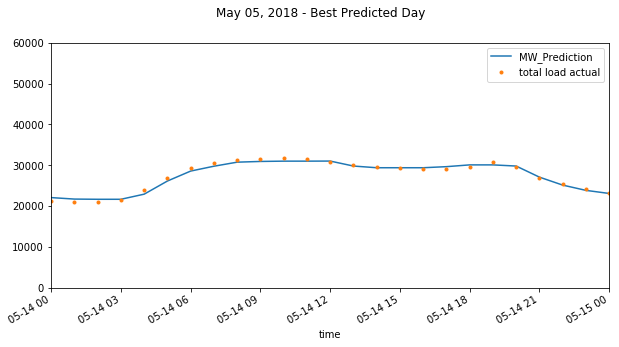

In [36]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)

_ = pjme_all[['MW_Prediction', 'total load actual']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='05-14-2018', upper = '05-15-2018')
plot = plt.suptitle('May 05, 2018 - Best Predicted Day')

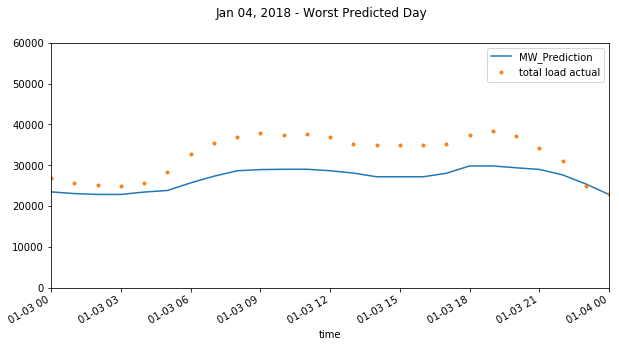

In [37]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)

_ = pjme_all[['MW_Prediction', 'total load actual']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='01-03-2018', upper = '01-04-2018')
plot = plt.suptitle('Jan 04, 2018 - Worst Predicted Day')

## Conclusion

Our XGBoost model has the Mean absolute percent accuracy (MAPA) of 94 percent.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX,SARIMAXResults
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

In [39]:
energy=pd.read_csv(r"F:\IBM\git\Forecasting\energy_dataset.csv")

weather=pd.read_csv(r"F:\IBM\git\Forecasting\weather_features.csv")

In [40]:
energy=energy.loc[:,['time','total load actual','price actual']]


In [41]:
weather=weather.loc[:,['dt_iso','temp','pressure','humidity','wind_speed','wind_deg','rain_3h','snow_3h','clouds_all']]

In [42]:
df=pd.merge(energy,weather,left_on='time',right_on='dt_iso')

In [43]:
df.head()

,time,total load actual,price actual,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,rain_3h,snow_3h,clouds_all
0,2015-01-01 00:00:00+01:00,25385.0,65.41,2015-01-01 00:00:00+01:00,270.475000,1001,77,1,62,0.0,0.0,0
1,2015-01-01 00:00:00+01:00,25385.0,65.41,2015-01-01 00:00:00+01:00,267.325000,971,63,1,309,0.0,0.0,0
2,2015-01-01 00:00:00+01:00,25385.0,65.41,2015-01-01 00:00:00+01:00,269.657312,1036,97,0,226,0.0,0.0,0
3,2015-01-01 00:00:00+01:00,25385.0,65.41,2015-01-01 00:00:00+01:00,281.625000,1035,100,7,58,0.0,0.0,0
4,2015-01-01 00:00:00+01:00,25385.0,65.41,2015-01-01 00:00:00+01:00,273.375000,1039,75,1,21,0.0,0.0,0


In [44]:
df.drop(columns=['dt_iso'],inplace=True)

In [45]:
# Fill null values using interpolation


df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [46]:
df.isna().sum()

time                 0
total load actual    0
price actual         0
temp                 0
pressure             0
humidity             0
wind_speed           0
wind_deg             0
rain_3h              0
snow_3h              0
clouds_all           0
dtype: int64

In [47]:
def season_calc(month):
    """adding season based on the data on SDGE's site -> https://www.sdge.com/whenmatters#how-it-works; 
       months from June to October are denoted as 'summer' and months from November to May as 'winter'. """
    if month in [6,7,8,9,10]:
        return "summer"
    else:
        return "winter"

In [48]:
df.time=pd.to_datetime(df.time)

In [49]:
df.set_index('time',inplace=True)

In [50]:
df=df[[ 'price actual', 'temp', 'pressure', 'humidity','wind_speed', 'wind_deg', 'rain_3h', 'snow_3h', 'clouds_all','total load actual']]

In [51]:
df.head()

,price actual,temp,pressure,humidity,wind_speed,wind_deg,rain_3h,snow_3h,clouds_all,total load actual
time,,,,,,,,,,
2014-12-31 23:00:00,65.41,270.475000,1001,77,1,62,0.0,0.0,0,25385.0
2014-12-31 23:00:00,65.41,267.325000,971,63,1,309,0.0,0.0,0,25385.0
2014-12-31 23:00:00,65.41,269.657312,1036,97,0,226,0.0,0.0,0,25385.0
2014-12-31 23:00:00,65.41,281.625000,1035,100,7,58,0.0,0.0,0,25385.0
2014-12-31 23:00:00,65.41,273.375000,1039,75,1,21,0.0,0.0,0,25385.0


In [52]:
split_date = '2018-01-01 01:00:00+01:00'
train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

In [53]:
train.head(1)

,price actual,temp,pressure,humidity,wind_speed,wind_deg,rain_3h,snow_3h,clouds_all,total load actual
time,,,,,,,,,,
2014-12-31 23:00:00,65.41,270.475,1001,77,1,62,0.0,0.0,0,25385.0


In [54]:
df.columns

Index(['price actual', 'temp', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'rain_3h', 'snow_3h', 'clouds_all', 'total load actual'],
      dtype='object')

In [55]:
# Create features from datetime index
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour', 'dayofweek','month', 'quarter', 'year', 'dayofyear',
            'dayofmonth', 'weekofyear','price actual', 'temp', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'rain_3h', 'snow_3h', 'clouds_all']]
    if label:
        y = df[label]
        return X, y
    return X

In [56]:
X_train, y_train = create_features(train, label='total load actual')
X_test, y_test = create_features(test, label='total load actual')

In [57]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = 50,
        verbose = False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
       gamma=0, gpu_id=-1, importance_type=None,
       interaction_constraints='', learning_rate=0.300000012,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
       monotone_constraints='()', n_estimators=1000, n_jobs=8,
       num_parallel_tree=1, objective='reg:squarederror', predictor='auto',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       subsample=1, tree_method='exact', validate_parameters=1,
       verbosity=None)

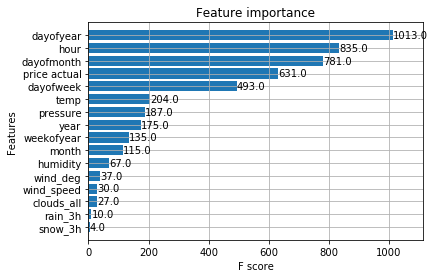

In [58]:
plot_importance(reg, height=0.8);

In [59]:
test['MW_Prediction'] = reg.predict(X_test)

In [60]:
test.head()

,price actual,temp,pressure,humidity,wind_speed,wind_deg,rain_3h,snow_3h,clouds_all,total load actual,date,hour,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear,MW_Prediction
time,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,17.9,286.15,1027,54,5,250,0.0,0.0,0,20589.0,2018-01-01 01:00:00,1,0,1,1,2018,1,1,1,21927.152344
2018-01-01 01:00:00,17.9,280.58,1030,61,5,280,0.0,0.0,0,20589.0,2018-01-01 01:00:00,1,0,1,1,2018,1,1,1,21932.046875
2018-01-01 01:00:00,17.9,279.70,1026,76,1,0,0.0,0.0,0,20589.0,2018-01-01 01:00:00,1,0,1,1,2018,1,1,1,21932.031250
2018-01-01 01:00:00,17.9,286.27,1018,62,6,270,0.0,0.0,0,20589.0,2018-01-01 01:00:00,1,0,1,1,2018,1,1,1,21942.726562
2018-01-01 01:00:00,17.9,283.15,1034,87,1,0,0.0,0.0,0,20589.0,2018-01-01 01:00:00,1,0,1,1,2018,1,1,1,21932.046875


In [61]:
all = pd.concat([test, train], sort = False)

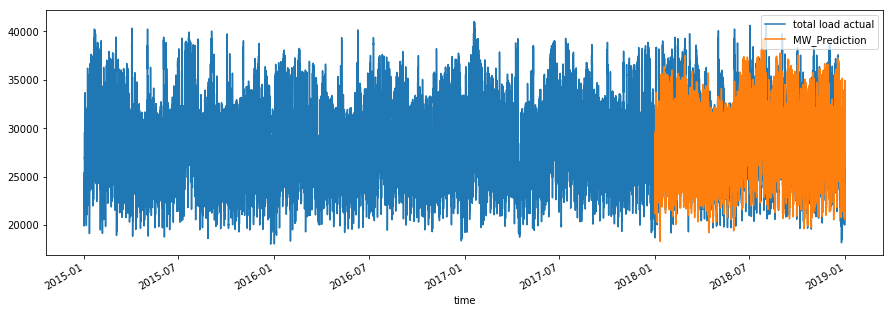

In [62]:
all[['total load actual', 'MW_Prediction']].plot(figsize=(15,5));

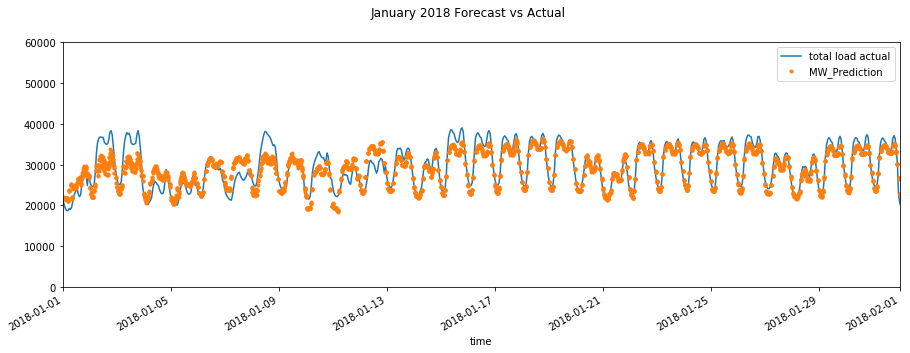

In [63]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = all[['total load actual', 'MW_Prediction']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='01-01-2018', upper='02-01-2018')
ax.set_ylim(0, 60000)

plot = plt.suptitle('January 2018 Forecast vs Actual')

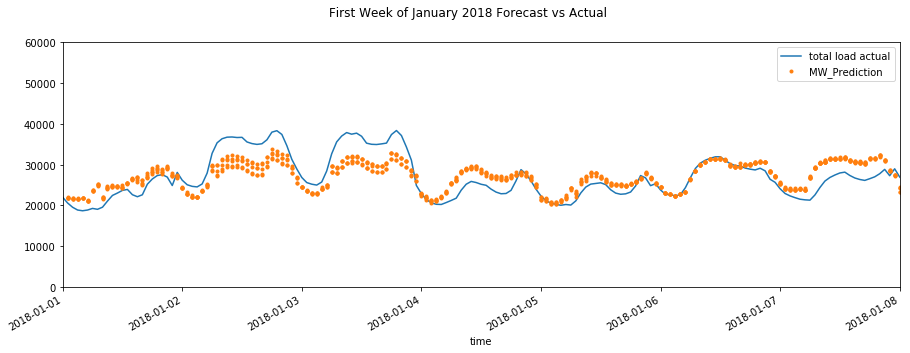

In [64]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = all[['total load actual', 'MW_Prediction']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='01-01-2018', upper='01-08-2018')
ax.set_ylim(0, 60000)

plot = plt.suptitle('First Week of January 2018 Forecast vs Actual')

In [65]:
# The MAPE (Mean Absolute Percent Error) measures the size of the error
# in percentage terms.
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [66]:
# Make predictions using the training and testing set
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [67]:
print('R^2   train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('MSE   train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))

print('RMSE  train: %.2f, test: %.2f' %
      (np.sqrt(mean_squared_error(y_train, y_train_pred)),
       np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('MAE   train: %.2f, test: %.2f' %
      (mean_absolute_error(y_train, y_train_pred),
       mean_absolute_error(y_test, y_test_pred)))

print('MAPE  train: %.2f, test: %.2f' %
      (mean_absolute_percentage_error(y_train, y_train_pred),
       mean_absolute_percentage_error(y_test, y_test_pred)))

R^2   train: 0.90, test: 0.76
MSE   train: 2073089.95, test: 5223337.88
RMSE  train: 1439.82, test: 2285.46
MAE   train: 1017.65, test: 1697.81
MAPE  train: 3.61, test: 5.86


In [68]:
# R^2   train: 0.85, test: 0.75
# MSE   train: 3043188.70, test: 5397958.50
# RMSE  train: 1744.47, test: 2323.35
# MAE   train: 1248.96, test: 1709.89
# MAPE  train: 4.39, test: 5.84

## Random forest Regressor

In [69]:
from sklearn.ensemble import RandomForestRegressor

In [71]:
from sklearn.model_selection import RandomizedSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [90]:
# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

In [91]:
# best_grid = grid_search.best_estimator_
# grid_accuracy = evaluate(best_grid, X_test, y_test)

In [73]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 1883.0097 degrees.
Accuracy = 93.62%.


In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

In [82]:
test['rf_MW_Prediction']=base_model.predict(X_test)

In [83]:
all = pd.concat([test, train], sort = False)

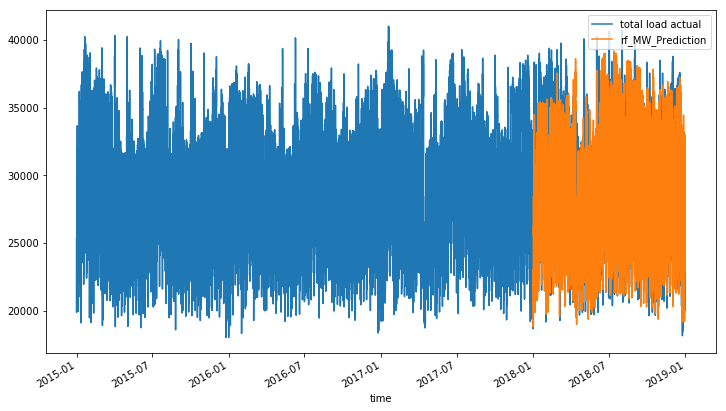

In [86]:
all[['total load actual', 'rf_MW_Prediction']].plot(figsize=(12,7))

In [88]:
# Make predictions using the training and testing set
y_train_pred = base_model.predict(X_train)
y_test_pred = base_model.predict(X_test)

In [89]:
print('R^2   train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('MSE   train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))

print('RMSE  train: %.2f, test: %.2f' %
      (np.sqrt(mean_squared_error(y_train, y_train_pred)),
       np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('MAE   train: %.2f, test: %.2f' %
      (mean_absolute_error(y_train, y_train_pred),
       mean_absolute_error(y_test, y_test_pred)))

print('MAPE  train: %.2f, test: %.2f' %
      (mean_absolute_percentage_error(y_train, y_train_pred),
       mean_absolute_percentage_error(y_test, y_test_pred)))

R^2   train: 1.00, test: 0.66
MSE   train: 33155.51, test: 7277605.98
RMSE  train: 182.09, test: 2697.70
MAE   train: 68.07, test: 1883.01
MAPE  train: 0.25, test: 6.38


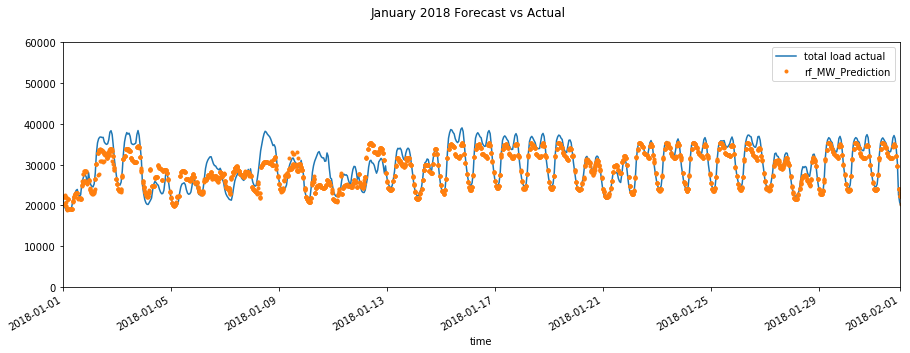

In [95]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = all[['total load actual', 'rf_MW_Prediction']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='01-01-2018', upper='02-01-2018')
ax.set_ylim(0, 60000)

plot = plt.suptitle('January 2018 Forecast vs Actual')

In [ ]:
fn=data.feature_names
cn=data.target_names
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(base_model.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')


In [96]:
test.columns

Index(['price actual', 'temp', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'rain_3h', 'snow_3h', 'clouds_all', 'total load actual',
       'date', 'hour', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'MW_Prediction', 'rf_MW_Prediction'],
      dtype='object')